<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [ ]:
# pip install torch
# !pip install typing-extensions --upgrade command

In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

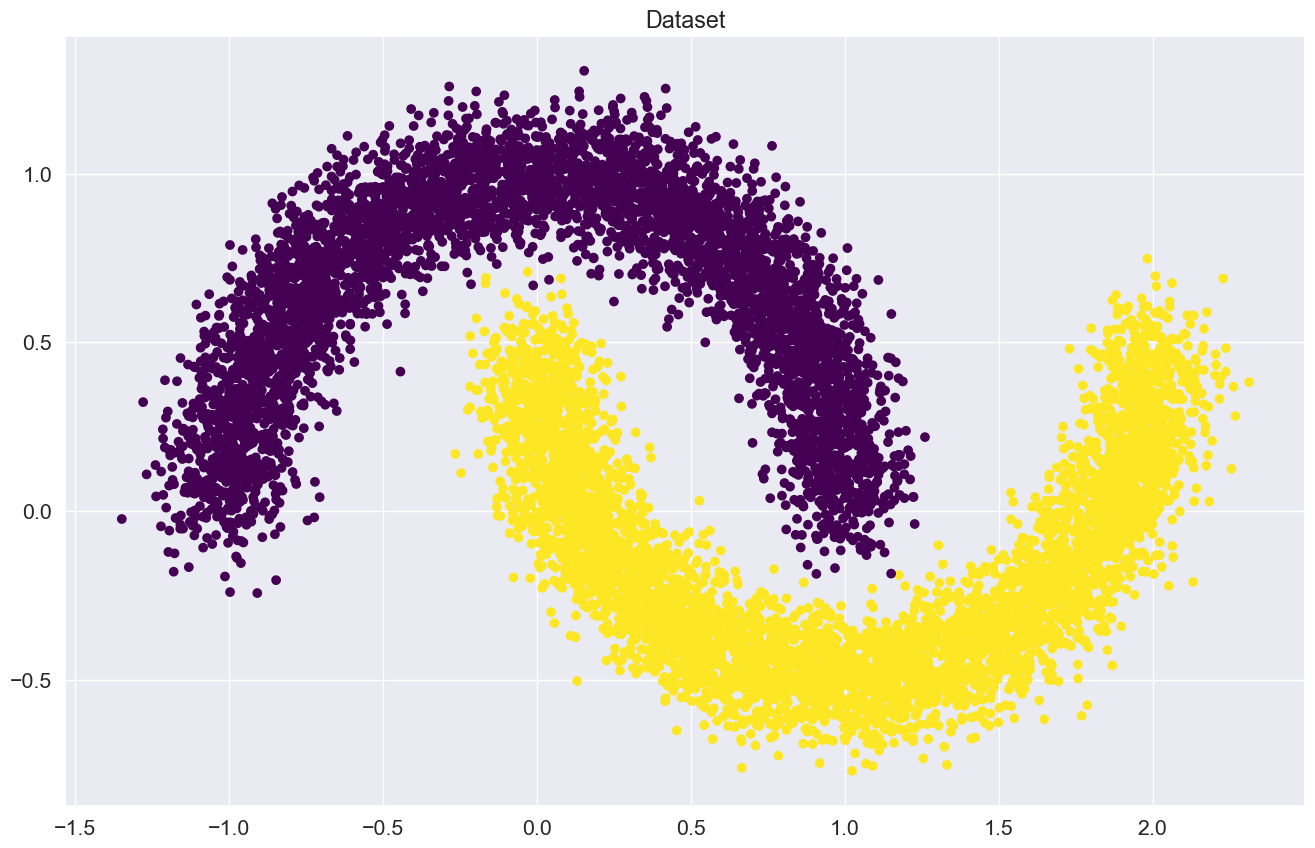

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t =  torch.FloatTensor(X_train)
y_train_t =  torch.FloatTensor(y_train)
X_val_t =  torch.FloatTensor(X_val)
y_val_t =  torch.FloatTensor(y_val)

Создаем `Dataset` и `DataLoader`.

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights_1 = nn.Parameter(torch.randn(in_features * 3, 12)) # 1 слой
        self.weights_2 = nn.Parameter(torch.randn(12, 6)) # 2 слой
        self.weights_3 = nn.Parameter(torch.randn(6, out_features)) # 3 слой
        self.bias = bias
        if bias:
            self.bias_term_1 = nn.Parameter(torch.randn(12)) # 1 слой
            self.bias_term_2 = nn.Parameter(torch.randn(6)) # 2 слой
            self.bias_term_3 = nn.Parameter(torch.randn(1)) # 3 слой

    def forward(self, x):
        # Нам даны 2 признака x1 и x2, этой информации мало для обучения модели.
        # Добавим еще 4 признака sin(x1), sin(x2), exp(x1), exp(x2).
        # Дополнительная информация позволит установить новые закономерности и лучше обучится модели.
        x = torch.cat((x, x.sin(), x.exp()), 1)

        # 1 слой
        x = x.matmul(self.weights_1) # Перемножаем матрицы.
        if self.bias:
            x += self.bias_term_1 # добавляем вектор смещения.
            
        # 2 слой
        x = x.clamp(min=0).matmul(self.weights_2) # Нелинейно преобразуем вхдной вектор и перемножаем с матрицой весов.
        if self.bias:
            x += self.bias_term_2 # добавляем вектор смещения.
        
        # 3 слой
        x = x.clamp(min=0).matmul(self.weights_3) # Нелинейно преобразуем вхдной вектор и перемножаем с матрицой весов.
        if self.bias:
            x += self.bias_term_3 # добавляем вектор смещения.
            
        return x

In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

При in_features = 2, а out_features= 1: 

weights_1 - матрица [6, 12],
bias_term_1 - вектор [12]

weights_2 - матрица [12, 6],
bias_term_2 - вектор [6]

weights_2 - вектор [6],
bias_term_2 - вектор [1]

Всего 169 обучаемых параметров

In [ ]:
# print('weights_1:')
# print(linear_regression.weights_1.shape)
# print(linear_regression.weights_1)

# print('bias_term_1:')
# print(linear_regression.bias_term_1.shape)
# print(linear_regression.bias_term_1)

# print('weights_2:')
# print(linear_regression.weights_2.shape)
# print(linear_regression.weights_2)

# print('bias_term_2:')
# print(linear_regression.bias_term_2.shape)
# print(linear_regression.bias_term_2)

# print('weights_3:')
# print(linear_regression.weights_3.shape)
# print(linear_regression.weights_3)

# print('bias_term_3:')
# print(linear_regression.bias_term_3.shape)
# print(linear_regression.bias_term_3)

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [9]:
tol = 1e-3
losses = []
max_epochs = 1000

# Заменяем prev_weights на zeros_like_1, zeros_like_2, zeros_like_3.
zeros_like_1 = torch.zeros_like(linear_regression.weights_1)
zeros_like_2 = torch.zeros_like(linear_regression.weights_2)
zeros_like_3 = torch.zeros_like(linear_regression.weights_3)

stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch) # Записываем предсказания модели на баче.
        loss =  loss_function(outp.view(-1), y_batch)# Расчитываем loss.
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp) # Расчитываем вероятность.
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        #   Вносим свои изменения с учётом всех весов.
        current_weights_1 = linear_regression.weights_1.detach().clone()
        current_weights_2 = linear_regression.weights_2.detach().clone()
        current_weights_3 = linear_regression.weights_3.detach().clone()

        #   Вносим свои изменения в  if.
        if ((zeros_like_1 - current_weights_1).abs().max() < tol  and 
            (zeros_like_2 - current_weights_2).abs().max() < tol  and
            (zeros_like_3 - current_weights_3).abs().max() < tol):
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        #   Сохраняем веса чтобы обратится к ним в следующей итерации.
        zeros_like_1 = current_weights_1
        zeros_like_2 = current_weights_2
        zeros_like_3 = current_weights_3
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.3125
Iteration: 100
Batch accuracy: 0.9453125
Iteration: 200
Batch accuracy: 0.9921875
Iteration: 300
Batch accuracy: 0.9921875

Iteration: 335.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:**  При каждом запуске ноутбука генерируются рандомные веса, поэтому кол-во итераций и Batch accuracy могут разнится.

Iteration: 869.Convergence. 
           Stopping iterations.
           Iteration: 800 Batch accuracy: 0.9921875

### Визуализируем результаты

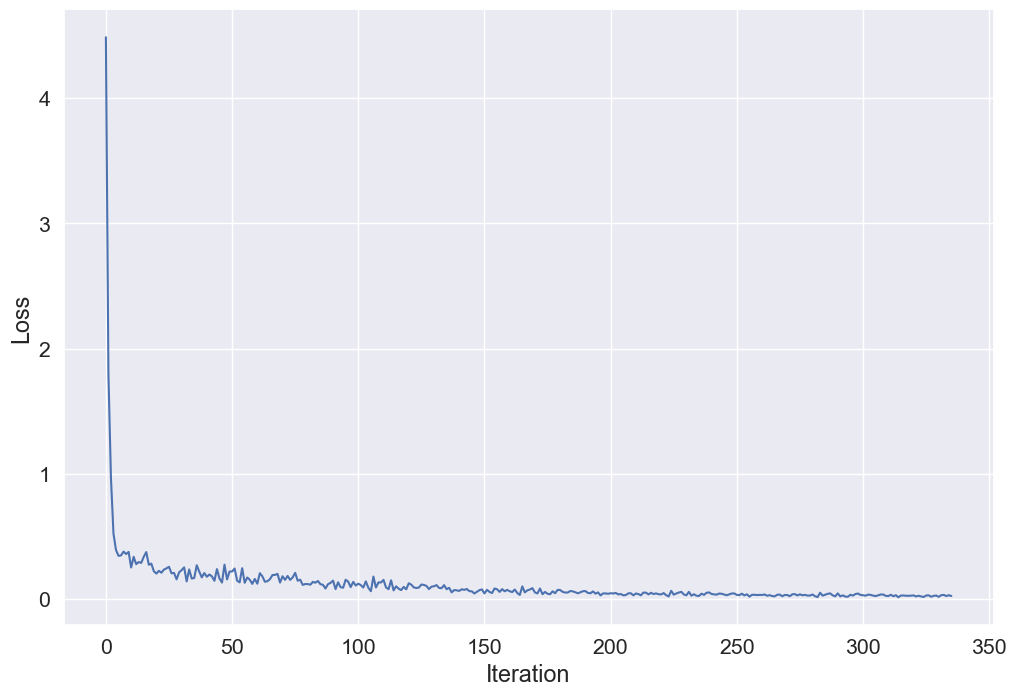

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

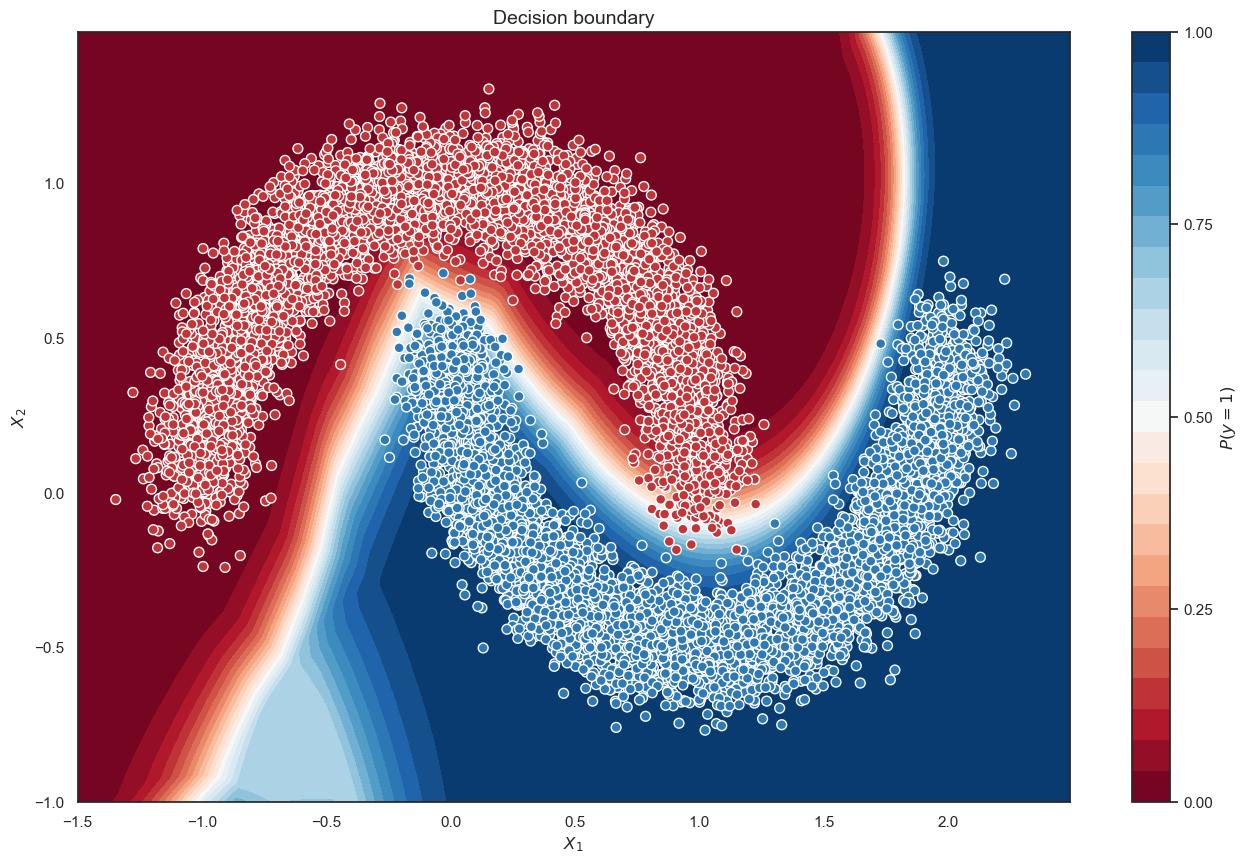

In [11]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [12]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    probabilities = np.array([])
    Y = np.array([])
    for x_batch, y in dataloader:
        preds = model(x_batch)  # Записываем предсказания модели на баче.
        proba = torch.sigmoid(preds).round() # Записываем вероятность для предсказаний модели.
        
        predictions = np.hstack((predictions, preds.numpy().flatten())) # Сохраняем предсказания модели со всех бачей.
        probabilities = np.hstack((probabilities, proba.numpy().flatten())) # Сохраняем вероятность со всех бачей.
        
        Y = np.hstack((Y, y.numpy().flatten())) # Сохраняем правильные ответы со всех бачей.
    return probabilities.flatten(), Y # Возвращаем предсказания модели и правильные ответы со всех бачей.

In [13]:
from sklearn.metrics import accuracy_score

# Получаем предсказания модели и правильные ответы со всех бачей.
y_pred, y_true = predict(val_dataloader, linear_regression)

# Конвертируем в int.
#func = nn.Sigmoid()
#y_pred = func(y_pred)

y_pred = y_pred.astype(int)
y_true = y_true.astype(int)

print('y_pred, y_true:')
print(y_pred, y_true)

print('y_pred.shape, y_true.shape:')
print(y_pred.shape, y_true.shape)

print('y_pred.dtype, y_true.dtype:')
print(y_pred.dtype, y_true.dtype)

# Считаем accuracy на test.
print('accuracy score:')
print(accuracy_score(y_true.round(), y_pred))

print('accuracy score normalize=False:')
print(accuracy_score(y_true, y_pred, normalize=False))

y_pred, y_true:
[1 1 0 ... 1 0 0] [1 1 0 ... 1 0 0]
y_pred.shape, y_true.shape:
(2500,) (2500,)
y_pred.dtype, y_true.dtype:
int32 int32
accuracy score:
0.9968
accuracy score normalize=False:
2492


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** При каждом запуске ноутбука генерируются рандомные веса, поэтому модель каждый раз обучается по разному.

accuracy score: 0.9968

accuracy score normalize=False: 2492

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [ ]:
# pip install torchvision

In [14]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=64,
        num_workers=0,
        shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=64,
        num_workers=0)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [15]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [16]:
activation = nn.ELU()

# Add layers to your sequential class
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 10),
#     nn.LogSoftmax(dim=1)
)

In [17]:
# Select a loss function nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [19]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            
            if k == "train": # Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                model.train()
                optimizer.zero_grad()
                logits = model(x_batch) # Предсказания модели.
                
            else: # Set model to ``eval`` mode and calculate outputs
                model.eval() 
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    logits = model(x_batch) # Предсказания модели.
            
            preds = logits.argmax(-1)
            correct = preds.eq(y_batch) # YOUR CODE GOES HERE
            correct = correct.sum() 
            all = 64 
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(logits, y_batch)
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9025519722814499
Loader: valid. Accuracy: 0.9487460191082803
Epoch: 2
Loader: train. Accuracy: 0.9562899786780383
Loader: valid. Accuracy: 0.9532245222929936
Epoch: 3
Loader: train. Accuracy: 0.9682169509594882
Loader: valid. Accuracy: 0.9625796178343949
Epoch: 4
Loader: train. Accuracy: 0.9731809701492538
Loader: valid. Accuracy: 0.9677547770700637
Epoch: 5
Loader: train. Accuracy: 0.9764625533049041
Loader: valid. Accuracy: 0.9651671974522293
Epoch: 6
Loader: train. Accuracy: 0.9787113539445629
Loader: valid. Accuracy: 0.9627786624203821
Epoch: 7
Loader: train. Accuracy: 0.982359408315565
Loader: valid. Accuracy: 0.9667595541401274
Epoch: 8
Loader: train. Accuracy: 0.9839918710021321
Loader: valid. Accuracy: 0.964171974522293
Epoch: 9
Loader: train. Accuracy: 0.9851579157782516
Loader: valid. Accuracy: 0.9705414012738853
Epoch: 10
Loader: train. Accuracy: 0.9868903251599147
Loader: valid. Accuracy: 0.9663614649681529


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [20]:
# elu_accuracy = test_activation_function(nn.ELU())
elu_accuracy = accuracy["valid"]


In [21]:
# Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)
# print('Список слоёв модели: ', model._modules)
# model._modules['2'] = nn.ReLU()
# model._modules['4'] = nn.ReLU()
# print('Список слоёв модели: ', model._modules)

def test_activation_function(activ):
    # Заменяем функцию активации на новую.
    model._modules['2'] = activ
    model._modules['4'] = activ
    
    # Так как мы будем обучать модель с новой функцией активации заресетим веса.
    for layer in model:
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:

                if k == "train": # Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                    model.train()
                    optimizer.zero_grad()
                    logits = model(x_batch) # Предсказания модели.

                else: # Set model to ``eval`` mode and calculate outputs
                    model.eval() 
                    with torch.no_grad():  # <--------- НЕ считаем градиенты
                        logits = model(x_batch) # Предсказания модели.

                preds = logits.argmax(-1)
                correct = preds.eq(y_batch) 
                correct = correct.sum() 
                all = 64 
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(logits, y_batch)
                    loss.backward()  # <--------------- считаем градиенты
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)

    return accuracy["valid"]



In [22]:
plain_accuracy = test_activation_function(nn.Identity())
relu_accuracy = test_activation_function(nn.ReLU())
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU(0.1))

Epoch: 1
Loader: train. Accuracy: 0.8749000533049041
Loader: valid. Accuracy: 0.9039609872611465
Epoch: 2
Loader: train. Accuracy: 0.902168843283582
Loader: valid. Accuracy: 0.9067476114649682
Epoch: 3
Loader: train. Accuracy: 0.90625
Loader: valid. Accuracy: 0.9041600318471338
Epoch: 4
Loader: train. Accuracy: 0.9085154584221748
Loader: valid. Accuracy: 0.8943073248407644
Epoch: 5
Loader: train. Accuracy: 0.9106643123667377
Loader: valid. Accuracy: 0.9140127388535032
Epoch: 6
Loader: train. Accuracy: 0.912213486140725
Loader: valid. Accuracy: 0.9125199044585988
Epoch: 7
Loader: train. Accuracy: 0.9137460021321961
Loader: valid. Accuracy: 0.910828025477707
Epoch: 8
Loader: train. Accuracy: 0.9151952292110874
Loader: valid. Accuracy: 0.912718949044586
Epoch: 9
Loader: train. Accuracy: 0.9159281716417911
Loader: valid. Accuracy: 0.9139132165605095
Epoch: 10
Loader: train. Accuracy: 0.9153284914712153
Loader: valid. Accuracy: 0.908140923566879
Epoch: 1
Loader: train. Accuracy: 0.909098480

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

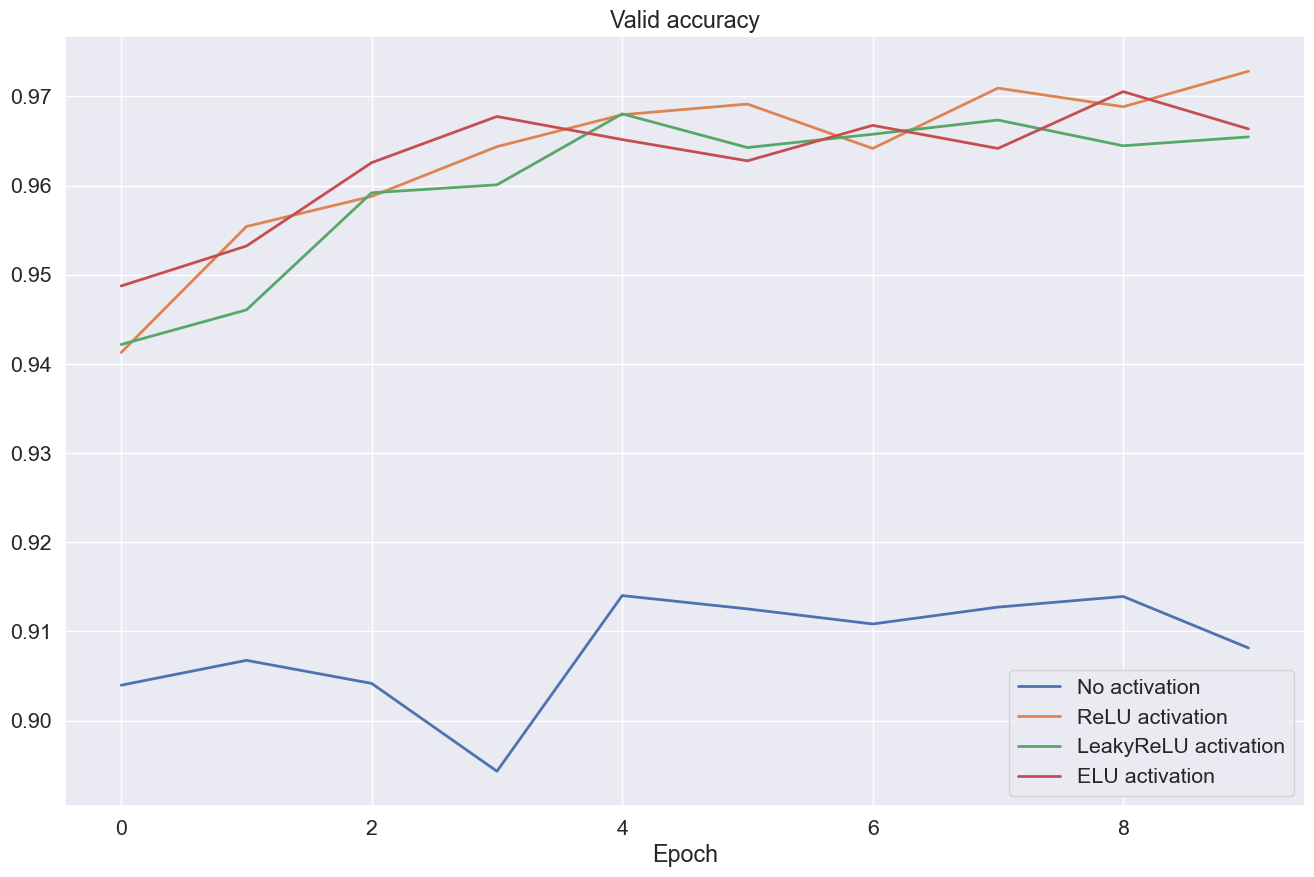

In [23]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

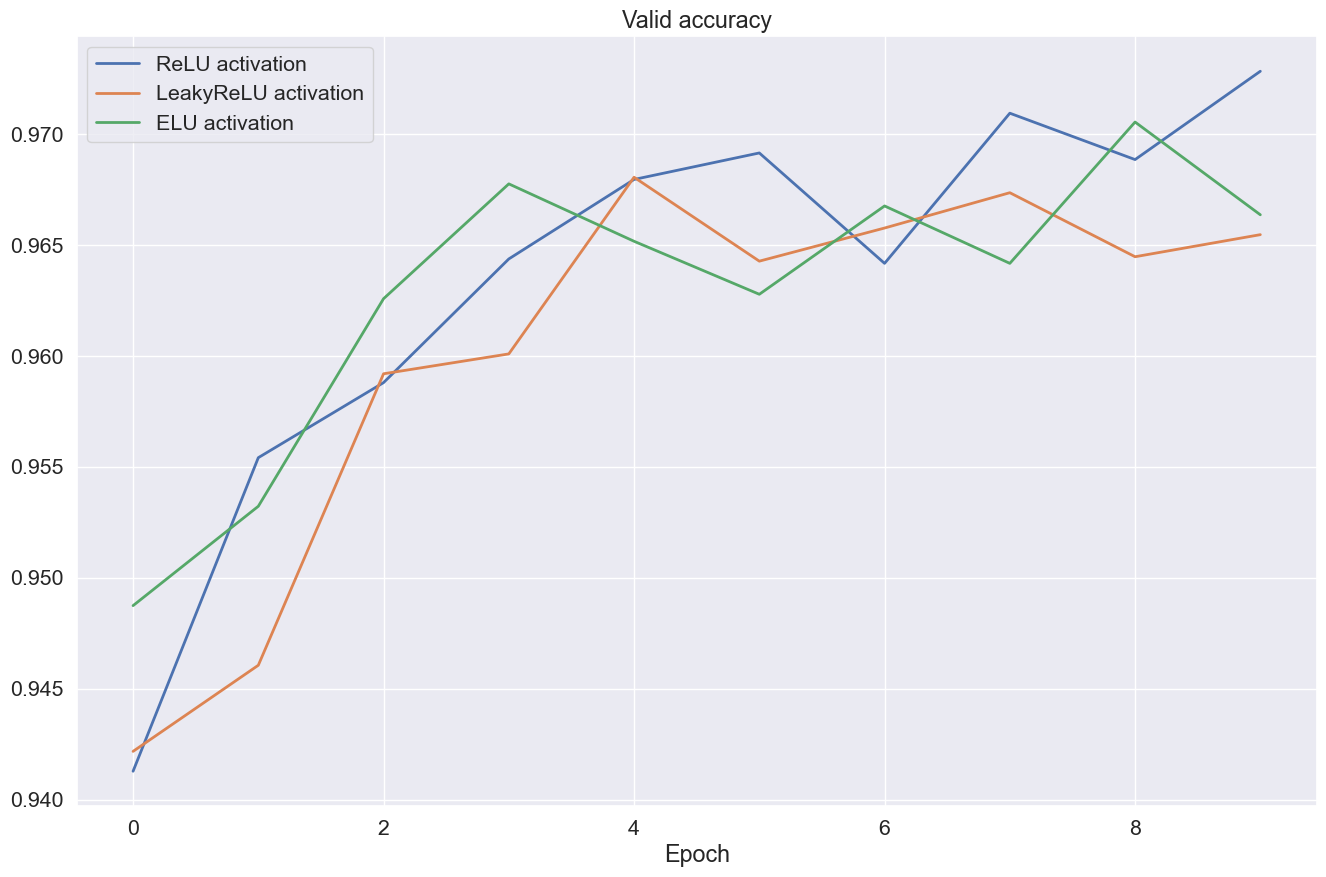

In [24]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:**    ELU activation

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [ ]:
# pip install opencv-python

In [25]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


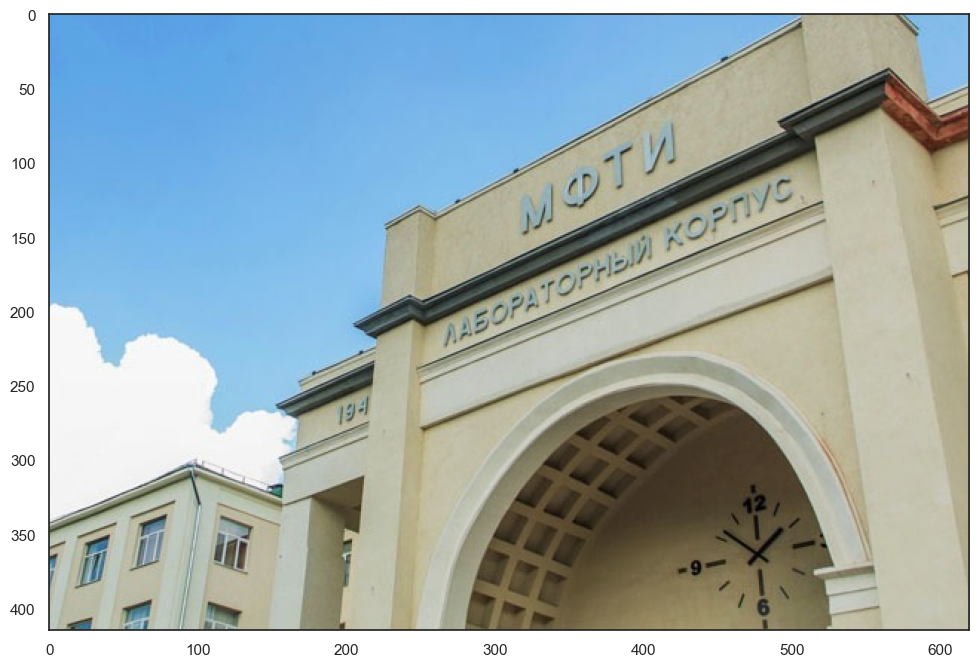

In [31]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [32]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
#print(img_t.shape)
kernel = torch.tensor([
[-1, -1, -1],
[-1, 8, -1],
[-1, -1, -1]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
print(kernel.shape)
#print(kernel)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #
print(result.shape)

torch.Size([3, 3, 3, 3])
torch.Size([3, 415, 620])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(415, 620, 3)


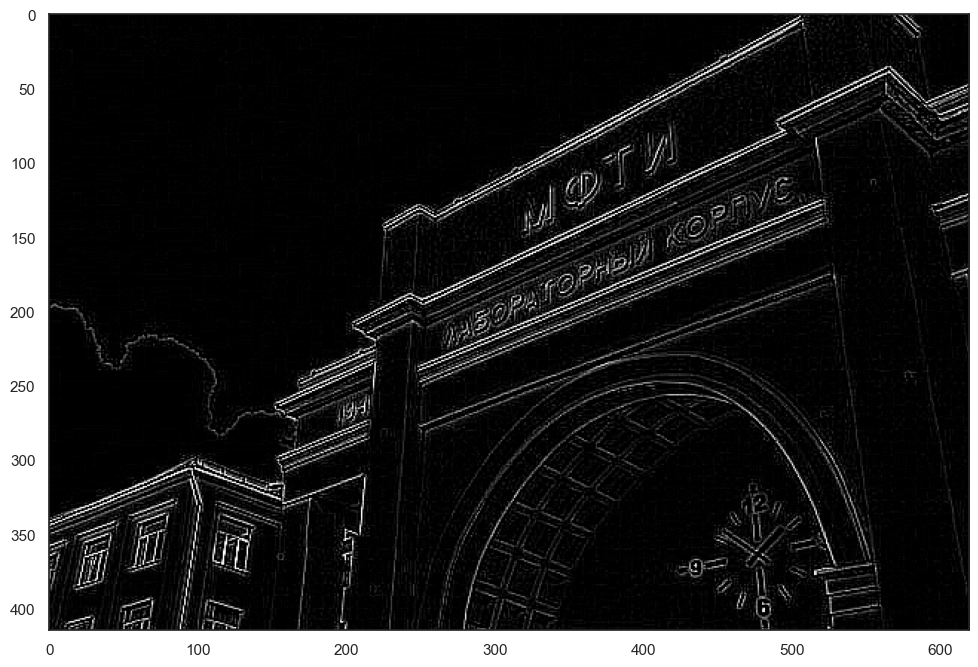

In [33]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3
print(result_np.shape)

plt.imshow(result_np)
plt.show()

In [34]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Open the image
img = np.array(Image.open("blue.jpg")).astype(np.uint8)

print(img[5, 5, 0])
print(img[5, 5, 1])
print(img[5, 5, 2])

0
163
232


**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**    

1 - Е - Размытие +

2 - Д - Увеличение резкости +

3 - A - Тождественное преобразование +

4 - В - Выделение вертикальных границ +

5 - Б - Выделение горизонтальных границ +

6 - Г - Выделение границ +

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [35]:
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        # pool of square window of size=2, stride=2
#         self.pool1 = nn.MaxPool2d(2, stride=1)
        self.conv2 = nn.Conv2d(6, 16, 3)
#         self.pool2 = nn.MaxPool2d(2, stride=1)
#         self.flatten = nn.Flatten(),
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [36]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [41]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            
            if k == "train": # Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                model.train()
                optimizer.zero_grad()
                logits = model(x_batch.to(device))
                
            else: # Set model to ``eval`` mode and calculate outputs
                model.eval() 
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    logits = model(x_batch.to(device))
            
            preds = logits.argmax(-1)
            correct = preds.eq(y_batch.to(device))
            correct = correct.sum() 
            all = 64 
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(logits.to(device), y_batch.to(device))
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9174440298507462
Loader: valid. Accuracy: 0.9722332802547771
Epoch: 2
Loader: train. Accuracy: 0.9761627132196162
Loader: valid. Accuracy: 0.9767117834394905
Epoch: 3
Loader: train. Accuracy: 0.9834421641791045
Loader: valid. Accuracy: 0.980593152866242
Epoch: 4
Loader: train. Accuracy: 0.986340618336887
Loader: valid. Accuracy: 0.9806926751592356
Epoch: 5
Loader: train. Accuracy: 0.9886727078891258
Loader: valid. Accuracy: 0.9834792993630573
Epoch: 6
Loader: train. Accuracy: 0.990171908315565
Loader: valid. Accuracy: 0.9813893312101911
Epoch: 7
Loader: train. Accuracy: 0.9918043710021321
Loader: valid. Accuracy: 0.9844745222929936
Epoch: 8
Loader: train. Accuracy: 0.9927871801705757
Loader: valid. Accuracy: 0.9814888535031847
Epoch: 9
Loader: train. Accuracy: 0.9936367270788913
Loader: valid. Accuracy: 0.9855692675159236
Epoch: 10
Loader: train. Accuracy: 0.993969882729211
Loader: valid. Accuracy: 0.9849721337579618


In [42]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

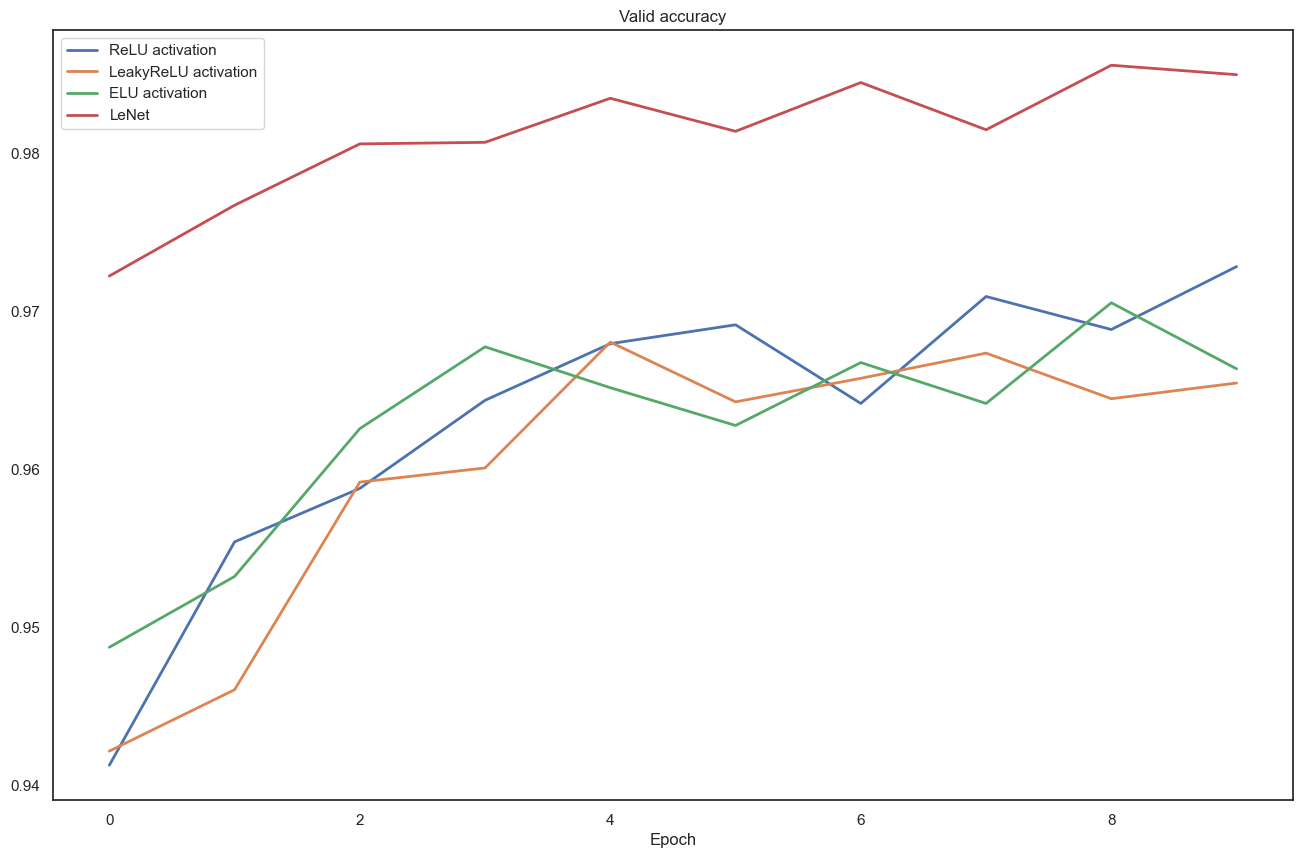

In [43]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**


Epoch: 10

Loader: train. Accuracy: 0.99

Loader: valid. Accuracy: 0.98